<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_07_Training%2C_Evaluating_and_Tuning_Models_(I).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-III Example: In-hospital Mortality Prediction (Cont'd)

# 1. Setting up

**Packages for data handling and visualization**

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

**Packages for data analysis and modelling**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

**Import the intermediate dataset and Authenication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in the previous tutorial, you can grant Colab access to your Google Drive and import the intermediate dataset to the current notebook.

Alternatively, when you are working on your own analysis, you may also put everything (e.g. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case, you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True) # you would need to authenicate yourself here

gdrive_rootpath = '/content/gdrive/MyDrive/'
# if you saved the file inside a folder in your Google Drive (instead of the base path),
# you would need to append the folder name to the above

Mounted at /content/gdrive


If you have followed the previous tutorial and execute all codes, a file named 'mimic_in_hosp_death_clean.csv' should appear in your Google Drive. In that case you can directly import it into the current notebook. Otherwise, you can download the intermediate dataset using the link below.

In [ ]:
if os.path.exists(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv'):
  print('Importing file from Google Drive...')
  df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')
else:
  print('Importing file from external link...')
  df = pd.read_csv('https://dl.dropboxusercontent.com/s/0g9rio6jz5zb8ow/mimic_in_hosp_death_clean.csv')

Importing file from Google Drive...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   DIAGNOSIS                         58951 non-null  object 
 7   MARITAL_STATUS                    58976 non-null  object 
 8   INSURANCE                         58976 non-null  object 
 9   LANGUAGE                          58976 non-null  object 
 10  RELIGION                          58976 non-null  object 
 11  ETHNICITY                         58976 non-null  object 
 12  GEND

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,3115,134067,EMERGENCY,2139-02-13 03:11:00,2139-02-20 07:33:00,NaN,STAB WOUND,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
1,7124,109129,EMERGENCY,2188-07-11 00:58:00,2188-08-01 12:04:00,NaN,PENILE LACERATION-CELLULITIS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
2,10348,121510,EMERGENCY,2133-04-16 21:12:00,2133-04-23 15:52:00,NaN,STATUS EPILEPTICUS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,0,0,1,0
3,9396,106469,EMERGENCY,2109-02-16 23:14:00,2109-02-23 12:01:00,NaN,SUBDURAL HEMATOMA,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
4,9333,133732,URGENT,2167-10-06 18:35:00,2167-10-16 13:13:00,NaN,CORONARY ARTERY DISEASE,UNKNOWN (DEFAULT),Private,ENGL,...,1,0,1,0,0,0,0,0,1,0


---

# 2. Training a Logistic Regression Model

## 2.1. Train-test Split

* Allow us to report an **unbiased performance metric** using data unseen by the model
* Help **mitigate overfitting** (model learns to fit the noise and error terms in the data) while we train machine learning models
* A 70-30 or 80-20 split is usually the most common.

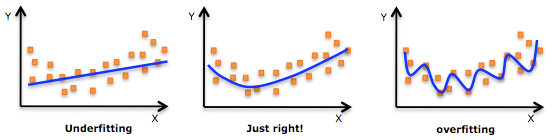

([Source](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6))

`IN_HOSP_DEATH` would be our prediction target. Here, let's define a list of 38 column names for features/inputs we would use in the model as not all columns are appropriate (e.g. `SUBJECT_ID`).

In [ ]:
features_list = ['GENDER_F', 'AGE', 'LOS', 'LOS_ICU',
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY',
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT',
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS',
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

38

Then, create a DataFrame (`X`) containing input features only as well as a Series (`y`) containing our prediction target.

In [ ]:
X = df[features_list]
y = df['IN_HOSP_DEATH']

Finally, use `train_test_split()` from the package [Scikit-learn](https://scikit-learn.org/stable/) to perform a train-test split.

Note that the function outputs four things: the input and output datasets for training and testing respectively.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,  # 20% of data belongs to the test set
                                                    random_state = 1, # make sure the split is the same across different devices for illustrative purposes
                                                    stratify = y)     # ensure the number of positive examples in the train and test sets are similar

In [ ]:
X_train.shape

(47180, 38)

In [ ]:
X_test.shape

(11796, 38)

As a result, our training and test set would include 47,180 and 11,796 admissions respectively.

## 2.2. Model Training

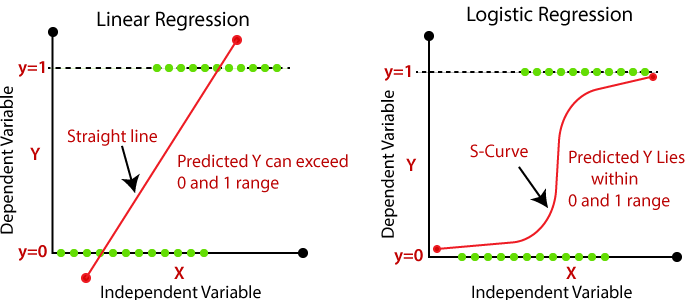

([Source](https://www.tpointtech.com/linear-regression-vs-logistic-regression-in-machine-learning))

In this example, we would be utilizing the package package [Scikit-learn](https://scikit-learn.org/stable/user_guide.html) heavily for modelling. In Scikit-learn, the general flow for training and using a model can be simplified into 3 steps:

1. **Specify a model to be trained**
  * Choose a type of model based on your task and dataset. A full list of available models in the package can be found [here](https://scikit-learn.org/stable/modules/classes.html).
  * Set the hyperparameters of the model.
  * Assign the model to a variable.
2. **Train the model**
  * Call the `.fit()` function using your cleaned train dataset.
3. **Make predictions**
  * Call the `.predict()` function using your cleaned test dataset.

In [ ]:
# 1. Specify a model to be trained
model_lr = LogisticRegression(random_state = 1,
                              n_jobs = -1) # use all available CPUs within your Colab notebook for computation

In [ ]:
# 2. Train the model
model_lr.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=1)

In [ ]:
# 3. Make predictions
y_pred_lr = model_lr.predict(X_test)
y_pred_lr

array([0, 0, 0, ..., 0, 0, 0])

Use `.predict_proba()` instead if you want probabilistic outputs over class outputs.

In [ ]:
y_pred_prob_lr = model_lr.predict_proba(X_test)
y_pred_prob_lr # here, the two columns represent the prob of 0 and 1 respectively

array([[0.93262806, 0.06737194],
       [0.9427264 , 0.0572736 ],
       [0.99321762, 0.00678238],
       ...,
       [0.91352512, 0.08647488],
       [0.97662272, 0.02337728],
       [0.97324441, 0.02675559]])

---

## 2.3. Evaluation (binary classification)

There are several metrics for evaluating the binary classification performances. In general, the most common reported metric for these kinds of machine learning problems are

* **Precision**. Proportion of correct predictions made among the predicted positive class
* **Recall**. Proportion of correct predictions made among the actual positive class. Also known as sensitivity
* **F1-score**. harmonic mean of precision and recall
* **Area under receiver operating characteristic curve (AUC)**. overall diagnostic ability across all classification probability cutoffs

These are all ranged between 0 and 1.

![binary classification metrics](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)

([Source](https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html))

<img src='https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg' width='40%'>

([Source](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))

In [ ]:
# to calculate accuracy:
accuracy_score(y_test, y_pred_lr)

0.9265852831468294

In [ ]:
# to calculate precision:
precision_score(y_test, y_pred_lr)

In [ ]:
# to calculate recall:
recall_score(y_test, y_pred_lr)

In [ ]:
# to calculate F1 score:
f1_score(y_test, y_pred_lr)

0.4976798143851508

In [ ]:
# to display multiple classification-related metrics:
print(classification_report(y_test, y_pred_lr, digits = 3))

              precision    recall  f1-score   support

           0      0.934     0.988     0.960     10625
           1      0.776     0.366     0.498      1171

    accuracy                          0.927     11796
   macro avg      0.855     0.677     0.729     11796
weighted avg      0.918     0.927     0.914     11796



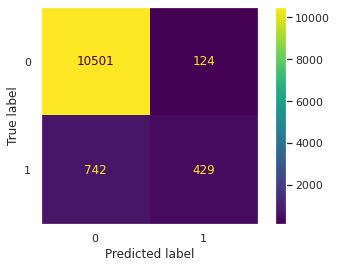

In [ ]:
# to visualise a confusion matrix using a heatmap:
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test)
plt.grid(False) # just to disable grid lines for this plot

Note that the colour in the above plot has little implications as the quantity of the two classes differ by too much. We can express them as ratios and percentages instead.

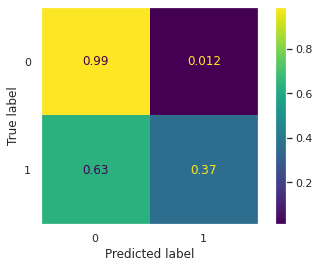

In [ ]:
# recall-related metrics (% of row)
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test, normalize = 'true')
plt.grid(False)

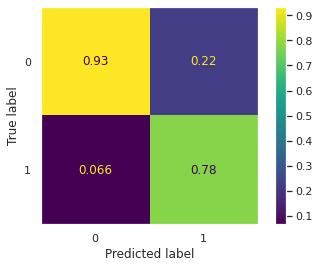

In [ ]:
# precision-related metrics (% of column)
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test, normalize = 'pred')
plt.grid(False)

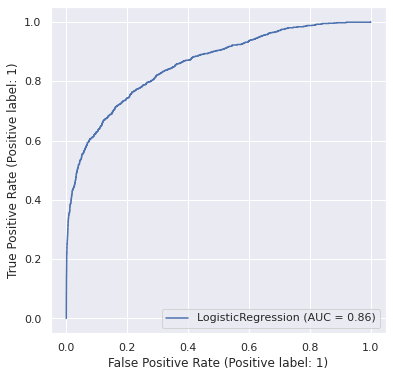

In [ ]:
# to plot an ROC:
fig, ax = plt.subplots(figsize=(6, 6)) # modify figure size
RocCurveDisplay.from_estimator(model_lr, X_test, y_test, ax = ax)

In [ ]:
# to calculate Area under ROC:
roc_auc_score(y_test, y_pred_prob_lr[:,1])

0.8573533329984427

**Some Observations**

* Despite having an accuracy of 92.6%, the overall F1-score is around 48%. The high accuracy is due to class imbalance and the model predicted the majority class (`IN_HOSP_DEATH == 0`) correctly.
* The recall for the positive examples is 34%, meaning that only around one-third of those who died within their hospital stay is successfully detected by the model.

---

# 3. Training a Random Forest Model

## 3.1. Train-test Split

As we have already made a train-test split when training the logistic regression model, we do not need to do this again. Having the same data split also allows for fair comparison between models.

---

## 3.2. Model Training

* A Random Forest model consists of **multiple Decision Tree** models.
* Each decision tree consists of **levels** of nodes that represent **yes/no questions**. By following these rules given by a decision tree, each sample arrives to the end node which outputs a prediction.
* Decision trees are trained by minimizing metrics such as gini score or **entropy**.
* Random Forest is trained by first training multiple decision trees with different subsets of the training dataset as inputs; then **aggregate the predictions from all decision trees** via a majority vote or averaging.

![Random Forest](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

([Source](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/))

We can follow the same 3-step process to train the model.

Define the configuration/hyperparameters of a random forest model. Here we specify that the model contains 200 decision trees.

In [ ]:
# 1. Specify a model to be trained
# Also define the configuration/hyperparameters of a random forest model.
# Here we specify that the model contains 200 decision trees.
model_rf = RandomForestClassifier(n_estimators = 200,
                                   random_state = 1,
                                   n_jobs = -1)

In [ ]:
# 2. Train the model
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=1)

In [ ]:
# 3. Make predictions
y_pred_rf = model_rf.predict(X_test)
y_pred_rf

array([1, 0, 0, ..., 0, 0, 0])

Use `.predict_proba()` instead if you want probabilistic outputs over class outputs.

In [ ]:
y_pred_prob_rf = model_rf.predict_proba(X_test)
y_pred_prob_rf # the two columns represent the prob of 0 and 1 respectively

array([[0.21 , 0.79 ],
       [0.88 , 0.12 ],
       [1.   , 0.   ],
       ...,
       [0.92 , 0.08 ],
       [0.985, 0.015],
       [1.   , 0.   ]])

---

## 3.3. Evaluation

In [ ]:
# to calculate accuracy:
accuracy_score(y_test, y_pred_rf)

0.937775517124449

In [ ]:
# to calculate F1 score:
f1_score(y_test, y_pred_rf)

0.5922222222222222

In [ ]:
# to display multiple classification-related metrics:
print(classification_report(y_test, y_pred_rf, digits = 3))

              precision    recall  f1-score   support

           0      0.943     0.991     0.966     10625
           1      0.847     0.455     0.592      1171

    accuracy                          0.938     11796
   macro avg      0.895     0.723     0.779     11796
weighted avg      0.933     0.938     0.929     11796



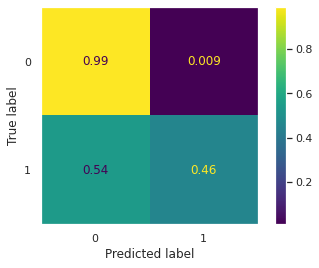

In [ ]:
# to visualise a confusion matrix using a heatmap:
# recall-related metrics (% of row)
ConfusionMatrixDisplay.from_estimator(model_rf, X_test, y_test, normalize = 'true')
plt.grid(False)

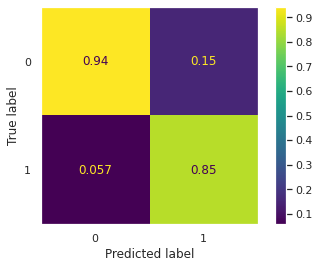

In [ ]:
# precision-related metrics (% of column)
ConfusionMatrixDisplay.from_estimator(model_rf, X_test, y_test, normalize = 'pred')
plt.grid(False)

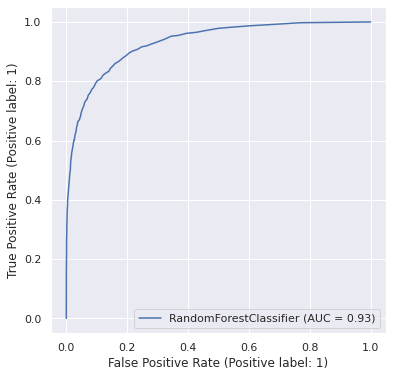

In [ ]:
# to plot an ROC:
fig, ax = plt.subplots(figsize=(6, 6)) # modify figure size
RocCurveDisplay.from_estimator(model_rf, X_test, y_test, ax = ax)

In [ ]:
# to calculate Area under ROC:
roc_auc_score(y_test, y_pred_prob_rf[:,1])

0.9306062390114029

Let us compare the performance of the two models with the table below:

In [ ]:
pd.DataFrame({
    'Random Forest': [
        accuracy_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        roc_auc_score(y_test, y_pred_prob_rf[:,1])
    ],
    'Logistic Regression': [
        accuracy_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_prob_lr[:,1])
    ]
    }, index=[
        'Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC'
    ])

,Random Forest,Logistic Regression
Accuracy,0.937776,0.926585
F1 Score,0.592222,0.497680
Precision,0.847377,0.775769
Recall,0.455167,0.366354
ROC,0.930606,0.857353


**Some Observations**

* This model outperforms the logistic regression model we have trained last tutorial in several metrics:
* The recall is still not optimal at 45.5%, meaning that only around half of those who died within their hospital stay is successfully detected by the model. Depending on the objectives of your model, it **could be beneficial to choose another cutoff point** for binary classification predictions rather than the default 0.5. One might prioritise recall over precision if the impact of having false negatives outweighs false positives. For example, for cancer prediction, minimising the risk of unidentified positive cases (hence delayed treatment) could outweigh the inconvenience and costs incurred by additional checkup appointments for negative cases.

### Tuning Cutoffs

As an example, let's lower the cutoff to 0.2 so that more patients will be classified as positive (hence higher recall at the cost of lower precision). We can use the probablistic outputs from the model (saved in `y_pred_prob_rf`) and define a new cutoff ourselves.

<AxesSubplot:ylabel='Count'>

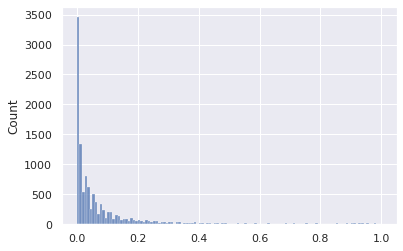

In [ ]:
sns.histplot(y_pred_prob_rf[:,1])

In [ ]:
y_pred_rf_cutoff20 = (y_pred_prob_rf[:,1] > 0.2) * 1
y_pred_rf_cutoff20

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
pd.Series(y_pred_rf).value_counts() # 0.5 as cutoff by default

0    11167
1      629
dtype: int64

In [ ]:
pd.Series(y_pred_rf_cutoff20).value_counts() # 0.2 as cutoff

0    10116
1     1680
dtype: int64

In [ ]:
# to display multiple classification-related metrics:
print(classification_report(y_test, y_pred_rf_cutoff20, digits = 3))

              precision    recall  f1-score   support

           0      0.972     0.925     0.948     10625
           1      0.527     0.757     0.622      1171

    accuracy                          0.909     11796
   macro avg      0.750     0.841     0.785     11796
weighted avg      0.928     0.909     0.916     11796



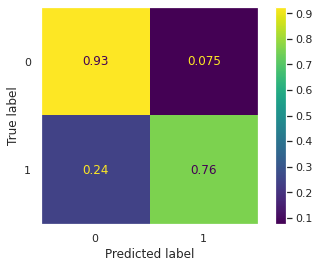

In [ ]:
# recall-related metrics (% of row)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_cutoff20, normalize = 'true')
plt.grid(False)

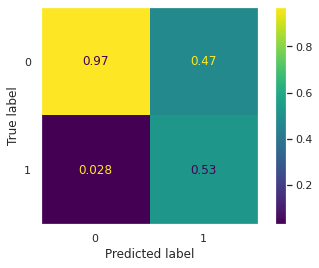

In [ ]:
# precision-related metrics (% of column)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_cutoff20, normalize = 'pred')
plt.grid(False)

* As we lower the cutoff, more patients were classified as positive (613 -> 1,680), leading to a better recall (45.5% -> 75.7%) and a worse precision (84.7% -> 52.7%)

---

## 3.4. Understanding a Random Forest Model

One major strength of tree-based machine learning models is its inherent ability to easily report **feature importance**. This could be useful to finding insights in the model.

In [ ]:
model_rf_importance = pd.Series(model_rf.feature_importances_, index = features_list).sort_values(ascending=False)
model_rf_importance

LAB_COUNT_DAY                       0.164881
CPT_COUNT_DAY                       0.081782
INPUTS_CV_COUNT_DAY                 0.080389
PRES_COUNT_DAY                      0.069207
LOS                                 0.066490
LOS_ICU                             0.061324
MICRO_COUNT_DAY                     0.061143
AGE                                 0.059491
OUTPUT_COUNT_DAY                    0.059189
PROC_COUNT_DAY                      0.054549
TRANSFER_COUNT_DAY                  0.049298
CALLOUT_COUNT_DAY                   0.045224
INPUTS_MV_COUNT_DAY                 0.039719
INSURANCE_Medicare                  0.008577
GENDER_F                            0.007219
ADMISSION_TYPE_EMERGENCY            0.006919
MARITAL_STATUS_MARRIED              0.006389
RELIGION_CATHOLIC                   0.006148
RELIGION_OTHERS                     0.006050
MARITAL_STATUS_SINGLE               0.005674
RELIGION_UNOBTAINABLE               0.005625
ETHNICITY_WHITE                     0.005170
MARITAL_ST

<AxesSubplot:>

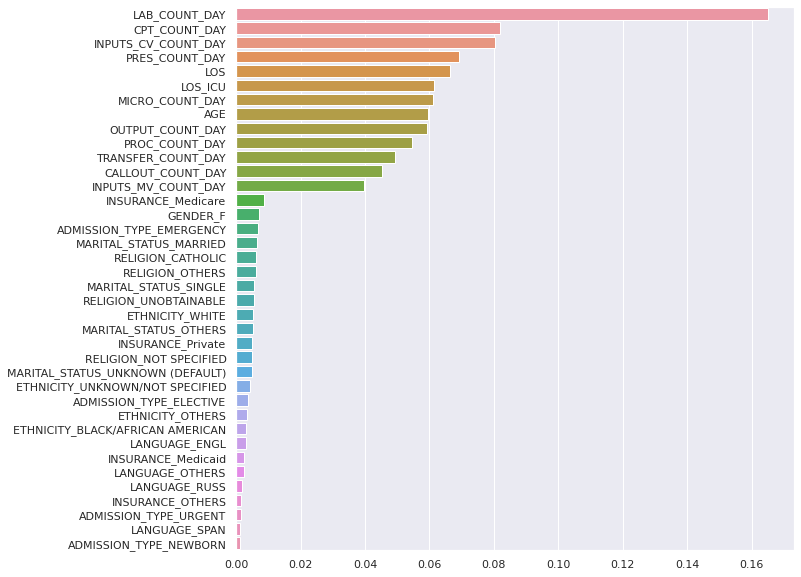

In [ ]:
plt.figure(figsize = (10, 10))
sns.barplot(x = model_rf_importance, y = model_rf_importance.index)

## 3.5. Saving and Loading your trained model

After training a model you might want to save your model to your Google Drive so that you do not need to re-train it next time. (As a side note, due to the random nature of most machine learning algorithms, if you did not set a random seed (`random_state`) while training, you would end up with a model with different trained parameters when you re-train a model)

In [ ]:
import joblib

To save:

In [ ]:
joblib.dump(model_rf, gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf.joblib') # specify your filename here

['/content/gdrive/MyDrive/mimic_in_hosp_mortality_model_rf.joblib']

To load:

In [ ]:
model_rf_loaded = joblib.load(gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf.joblib') # specify your filename here

In [ ]:
model_rf_loaded

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=1)

# References

* [Which machine learning algorithm should I use?](https://blogs.sas.com/content/subconsciousmusings/2020/12/09/machine-learning-algorithm-use/)
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet-2.png)
* [Decision Tree vs. Random Forest – Which Algorithm Should you Use?](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/)
* [Train/Test Split and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
